heres what the dataframe looks like btw:
   Time (ms)  Centroid_X  Centroid_Y  Feature
0          0  -18.112448   -7.618048       39
1          1  -13.046840   -9.590575       39
2          2   -8.764083  -12.284308       39
3          3   -2.110503  -12.777150       39
4          4    1.029483  -13.182605       39
5          5    5.663209  -10.902855       39
6          6    6.456484   -9.254714       39
7          7    2.735900   -3.856508       39
8          8   -0.484103   -0.866501       39
9          9   -5.195110    3.019698       39
[-18.112448 -13.04684   -8.764083 ... -21.287073 -22.94848  -22.354143]
[ -7.618048   -9.590575  -12.284308  ...  -1.4127754  -2.2394783
  -5.196636 ]
[[-18.112448   -7.618048 ]
 [-13.04684    -9.590575 ]
 [ -8.764083  -12.284308 ]
 ...
 [-16.89624    14.82285  ]
 [-14.328587   12.191551 ]
 [-11.754089    3.9635835]]
10000
epoch number 1,test rmse_x=6.015 μm,test rmse_y=10.038 μm
epoch number 11,test rmse_x=4.225 μm,test rmse_y=4.375 μm
epoch number

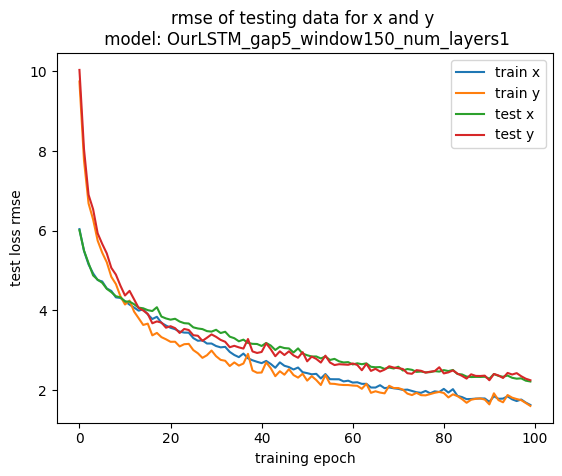

epoch number 1,test rmse_x=6.337 μm,test rmse_y=9.023 μm
epoch number 11,test rmse_x=4.133 μm,test rmse_y=4.051 μm
epoch number 21,test rmse_x=3.429 μm,test rmse_y=3.346 μm
epoch number 31,test rmse_x=3.005 μm,test rmse_y=3.016 μm
epoch number 41,test rmse_x=2.696 μm,test rmse_y=2.650 μm
epoch number 51,test rmse_x=2.529 μm,test rmse_y=2.486 μm
epoch number 61,test rmse_x=2.404 μm,test rmse_y=2.443 μm
epoch number 71,test rmse_x=2.260 μm,test rmse_y=2.308 μm
epoch number 81,test rmse_x=2.229 μm,test rmse_y=2.199 μm
epoch number 91,test rmse_x=2.167 μm,test rmse_y=2.140 μm


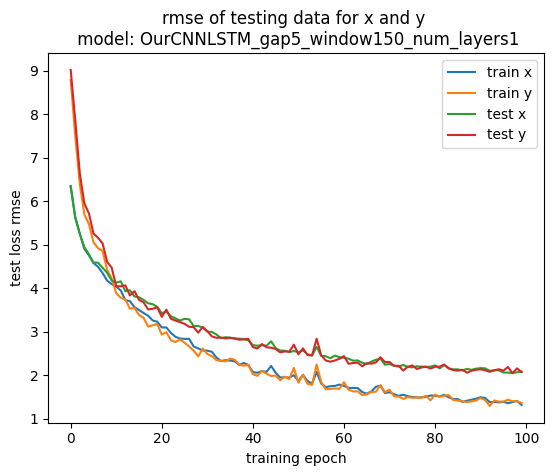

epoch number 1,test rmse_x=6.655 μm,test rmse_y=10.694 μm
epoch number 11,test rmse_x=6.530 μm,test rmse_y=10.580 μm
epoch number 21,test rmse_x=6.414 μm,test rmse_y=10.546 μm
epoch number 31,test rmse_x=6.435 μm,test rmse_y=10.540 μm
epoch number 41,test rmse_x=6.466 μm,test rmse_y=10.557 μm
epoch number 51,test rmse_x=6.431 μm,test rmse_y=10.606 μm
epoch number 61,test rmse_x=6.368 μm,test rmse_y=10.515 μm
epoch number 71,test rmse_x=6.292 μm,test rmse_y=10.523 μm
epoch number 81,test rmse_x=6.424 μm,test rmse_y=10.470 μm


KeyboardInterrupt: 

In [1]:
#libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

#data loading
df= dataframe = pd.read_feather("combined_centroid_data.feather")
x=df["Centroid_X"].values #.values is a pd attribute #gta take .values attribute to remove all the indexing, just returns array
y=df["Centroid_Y"].values
our_data= np.stack([x,y], axis=1) #stack invents a new axis, we tryna couple the [x_i y_i]
our_data = reduced_size= our_data[:10000] #the paper didnt use all the gazilliopn timesteps, theu used 10**5 i think. but it'll take way to long to run for our purposes, like several days.
print("heres what the dataframe looks like btw:")
print(df[:10])
print(x)
print(y)
print(our_data)
print(len(our_data))

#hyperparams to keep fixed
epochs= 100 #if it doesnt converge, i gotta adjust
batch_siz= 128 #just depending on speed mostly, big minib. faster
lr=.002
hidden=64 #REMEMBER THIS GOTTA B DIVIDISIBLE B nhead WHICH I PUT AS 4 FOR THRANDFORMER
#lets create a class to return input and output data 

class OurJitterDataset():
    def __init__(self,data,window,gap):
        self.data=data
        self.window=window
        self.gap=gap

    def __len__(self): #i use this s.t. i can run .random_split down below
        return len(self.data)-self.window-self.gap #also this makes it so we dont go outside the data!
    
    def __getitem__(self,i):
        input= torch.tensor(self.data[i:i+self.window], dtype=torch.float32) #thisll b 600,2
        output=torch.tensor( self.data[i+self.window+self.gap], dtype=torch.float32) #thisll b 2,. the output prediction
        return input,output
    
# MODELS ########################
#### LSTM
#lets roll out the model
class OurLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.lstm=nn.LSTM(2,hidden_size=hidden, num_layers=num_layers,batch_first=True)
        self.out_proj=nn.Linear(hidden,2)

    def forward(self,x):
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)  #
        return self.out_proj(final_hidden_state[-1]) #last layer hidden state, equiv to [0] for us cuz we just have 1 layer
#### LSTM+CNN
class OurCNNLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.conv= nn.Conv1d(2,32,kernel_size=5,padding=2)  
        self.lstm= nn.LSTM(32,hidden_size=hidden,num_layers=num_layers,batch_first=True)
        self.out_proj= nn.Linear(hidden, 2)
    
    def forward(self, x):
        x= x.permute(0,2,1)        
        x= torch.relu(self.conv(x))  
        x= x.permute(0,2,1)      
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)
        return self.out_proj(final_hidden_state[-1])
#### TRANSF
class OurTransformer(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.input_proj=nn.Linear(2,hidden)
        encoder_layer=nn.TransformerEncoderLayer(d_model=hidden,nhead=4,batch_first=True)
        self.transformer= nn.TransformerEncoder(encoder_layer,num_layers=num_layers)
        self.out_proj= nn.Linear(hidden,2)
    
    def forward(self,x):
        x= self.input_proj(x)         
        x= self.transformer(x)         
        return self.out_proj(x[:, -1])   #last timestep
                    


#the 3 hyperparams to vary
for gap in [5,10,20]:
    for window in [150,300,600]:

        #load up the data. we can put it here bc it only depends on gap and window, not num layers in the model
        our_dataset = OurJitterDataset(our_data,window,gap)
        train_size=int(.8*len(our_dataset))
            
        train_data,test_data= torch.utils.data.random_split(our_dataset,[train_size,len(our_dataset)-train_size])
        train_loader= DataLoader(train_data,batch_size=batch_siz,shuffle=True)
        test_loader= DataLoader(test_data,batch_size=batch_siz,shuffle=True)

        for num_layers in [1,2,3]:
            for model_class in [OurLSTM, OurCNNLSTM , OurTransformer]:

                our_model = model_class(hidden,num_layers) #instantiating and initializing the model based on the model class which we loop over
                # -------------------------------------------
                ###########################################here!!!!!!!!!!
                optimizer=torch.optim.Adam(our_model.parameters(),lr=lr)
                loss_fn = nn.MSELoss()

                train_rmse_list_x=[]
                train_rmse_list_y=[]
                test_rmse_list_x=[]
                test_rmse_list_y=[]
                train_loss_list=[]
                test_loss_list=[]

                #NOTICE! a thing to be mindful of here is that the model mse is taken per batch whereas rmse x list is taken per epoch... i will keep it like this because we dont need the model mse anyway, its just extra information, and rmse is more interpretable for our task anyway!

                for epoch in range(epochs):
                    our_model.train()
                    for inp,target in train_loader:
                        pred=our_model(inp)
                        l=loss_fn(pred, target)
                        train_loss_list.append(l.item()) #.item() gets the value... bc remember, l will have gradient attched to it
                        optimizer.zero_grad()
                        l.backward()
                        optimizer.step()
                

                    our_model.eval() #so we disable dropout
                    
                    train_errors=[] #this is rmse
                    test_errors=[] #this is rmse

                    #lets look at the rmse
                    with torch.no_grad(): #just makes the runs a little faster by disabling the whole computational graph stuff. it matters alot actually when u run big models.
                        for inp,target in train_loader:
                            pred= our_model(inp)
                            train_errors.append((pred-target).numpy())
                    train_errors=np.concatenate(train_errors)
                    rmse_x= np.sqrt((train_errors[:,0]**2).mean())
                    rmse_y= np.sqrt((train_errors[:,1]**2).mean())
                    train_rmse_list_x.append(rmse_x)
                    train_rmse_list_y.append(rmse_y)


                    with torch.no_grad():
                        for inp,target in test_loader:
                            pred= our_model(inp)
                            test_errors.append((pred-target).numpy())
                            test_loss_list.append(loss_fn(pred,target).item())
                    test_errors=np.concatenate(test_errors)
                    rmse_x= np.sqrt((test_errors[:,0]**2).mean())
                    rmse_y= np.sqrt((test_errors[:,1]**2).mean())
                    test_rmse_list_x.append(rmse_x)
                    test_rmse_list_y.append(rmse_y)
                    if epoch%10==0:
                        print(f"epoch number {epoch+1},test rmse_x={rmse_x:.3f} μm,test rmse_y={rmse_y:.3f} μm")

                fig=plt.figure()
                ax=fig.add_subplot()
                ax.plot(train_rmse_list_x,label="train x")
                ax.plot(train_rmse_list_y,label="train y")
                ax.plot(test_rmse_list_x,label="test x")
                ax.plot(test_rmse_list_y,label="test y")
                ax.legend()
                ax.set_xlabel("training epoch")
                ax.set_ylabel("test loss rmse")
                ax.set_title(f"rmse of data for x and y \n model: {model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}")
                
                #all the plots!!!! all plots are gonna get saved into the directory, so the folder we store this file in 
                plt.savefig(f"plot_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}")                        #turns out u gotta save before showing lest u get an empty plot. also use the name dunders to avoid those classic ugly brackets u get othewise
                #lets save the trained model. lemme just give it unmistakeable names:
                torch.save(our_model.state_dict(), f"params_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}")


                np.save(f"train_rmse_x_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", train_rmse_list_x)
                np.save(f"train_rmse_y_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", train_rmse_list_y)
                np.save(f"test_rmse_x_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", test_rmse_list_x)
                np.save(f"test_rmse_y_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", test_rmse_list_y)
                np.save(f"train_loss_list_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", train_loss_list) #we can also plot this later shud we find it interesting. but rn lets not overpower ourselves, rmse is what ewe care about anyway. also these guys are gonna be per batchw whereas the rmse guys are per epoch
                np.save(f"test_loss_list_{model_class.__name__}_gap{gap}_window{window}_num_layers{num_layers}", test_loss_list)

                plt.show()

# below is the same code, except in the way we originally wrote it, which is ipynb format. code above however runs grid search loop, hence all in one cell (the in loop above also we have added a few things things like torch.save(), plt.save() etc.) also just load w np.load etc the saved stuff from above so we can put it in our paper

### experimenting with various architectures beyond MLP :-)
##############################################################
#### 1. LSTM
#### 2. CNN + LSTM
#### 3. Transformer
##############################################################
### for each of these, i'll vary: 
#### 1. num_layers
#### 2. hidden size (aka dimensionality)
#### 3. Input window length (150,300,600)... it could be that too many time-samples cause overfitting
##############################################################
#####   technically, we could do a grid search and try like 3 combos of each hyperparam, i.e. 3x3x3=27 runs for each architecture type
#####   however, i'll just run "fix and vary". it's unlikely that there are interactions here between the hyperparams


In [ ]:
#libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

#data loading
df= dataframe = pd.read_feather("combined_centroid_data.feather")
x=df["Centroid_X"].values #.values is a pd attribute #gta take .values attribute to remove all the indexing, just returns array
y=df["Centroid_Y"].values
our_data= np.stack([x,y], axis=1) #stack invents a new axis, we tryna couple the [x_i y_i]
our_data = reduced_size= our_data[:10000] #the paper didnt use all the gazilliopn timesteps, theu used 10**5 i think

In [ ]:
print("heres what the dataframe looks like btw:")
print(df[:10])
print(x)
print(y)
print(our_data)
print(len(our_data))

heres what the dataframe looks like btw:
   Time (ms)  Centroid_X  Centroid_Y  Feature
0          0  -18.112448   -7.618048       39
1          1  -13.046840   -9.590575       39
2          2   -8.764083  -12.284308       39
3          3   -2.110503  -12.777150       39
4          4    1.029483  -13.182605       39
5          5    5.663209  -10.902855       39
6          6    6.456484   -9.254714       39
7          7    2.735900   -3.856508       39
8          8   -0.484103   -0.866501       39
9          9   -5.195110    3.019698       39
[-18.112448 -13.04684   -8.764083 ... -21.287073 -22.94848  -22.354143]
[ -7.618048   -9.590575  -12.284308  ...  -1.4127754  -2.2394783
  -5.196636 ]
[[-18.112448    -7.618048  ]
 [-13.04684     -9.590575  ]
 [ -8.764083   -12.284308  ]
 ...
 [ -0.63192445   1.02285   ]
 [  3.8037598    1.02285   ]
 [  8.485918     0.28353426]]
1000


In [ ]:
#hyperparams to keep fixed
epochs= 100 #if it doesnt converge, i gotta adjust
batch_siz= 128 #just depending on speed mostly, big minib. faster
gap=20
lr=.002

#the 3 hyperparams to vary
num_layers=3
hidden=64 #REMEMBER THIS GOTTA B DIVIDISIBLE B nhead WHICH I PUT AS 4 FOR THRANDFORMER
window=600

In [ ]:
#lets create a class to return input and output data 

class OurJitterDataset():
    def __init__(self,data,window,gap):
        self.data=data
        self.window=window
        self.gap=gap

    def __len__(self): #i use this s.t. i can run .random_split down below
        return len(self.data)-self.window-self.gap #also this makes it so we dont go outside the data!
    
    def __getitem__(self,i):
        input= torch.tensor(self.data[i:i+self.window], dtype=torch.float32) #thisll b 600,2
        output=torch.tensor( self.data[i+self.window+self.gap], dtype=torch.float32) #thisll b 2,. the output prediction
        return input,output

In [ ]:
#load up the data
our_dataset = OurJitterDataset(our_data,window,gap)
train_size=int(.8*len(our_dataset))
    
train_data,test_data= torch.utils.data.random_split(our_dataset,[train_size,len(our_dataset)-train_size])
train_loader= DataLoader(train_data,batch_size=batch_siz,shuffle=True)
test_loader= DataLoader(test_data,batch_size=batch_siz,shuffle=True)


# MODELS ########################

#### LSTM

In [ ]:
#lets roll out the model
class OurLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.lstm=nn.LSTM(2,hidden_size=hidden, num_layers=num_layers,batch_first=True)
        self.out_proj=nn.Linear(hidden,2)

    def forward(self,x):
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)  #
        return self.out_proj(final_hidden_state[-1]) #last layer hidden state, equiv to [0] for us cuz we just have 1 layer

#### LSTM+CNN

In [ ]:
class OurCNNLSTM(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.conv= nn.Conv1d(2,32,kernel_size=5,padding=2)  
        self.lstm= nn.LSTM(32,hidden_size=hidden,num_layers=num_layers,batch_first=True)
        self.out_proj= nn.Linear(hidden, 2)
    
    def forward(self, x):
        x= x.permute(0,2,1)        
        x= torch.relu(self.conv(x))  
        x= x.permute(0,2,1)      
        output_of_the_lstm,(final_hidden_state,more_irrelevant_stuff)= self.lstm(x)
        return self.out_proj(final_hidden_state[-1])

#### TRANSF

In [ ]:
class OurTransformer(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.input_proj=nn.Linear(2,hidden)
        encoder_layer=nn.TransformerEncoderLayer(d_model=hidden,nhead=4,batch_first=True)
        self.transformer= nn.TransformerEncoder(encoder_layer,num_layers=num_layers)
        self.out_proj= nn.Linear(hidden,2)
    
    def forward(self,x):
        x= self.input_proj(x)         
        x= self.transformer(x)         
        return self.out_proj(x[:, -1])   #last timestep

# -------------------------------------------

In [ ]:
our_model=OurTransformer(hidden,num_layers)
optimizer=torch.optim.Adam(our_model.parameters(),lr=lr)
loss = nn.MSELoss()

In [ ]:
rmse_list_x=[]
rmse_list_y=[]

for epoch in range(epochs):
    our_model.train()
    for inp,target in train_loader:
        pred=our_model(inp)
        l=loss(pred, target)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    our_model.eval()
    errors=[]
    with torch.no_grad():
        for inp,target in test_loader:
            pred= our_model(inp)
            errors.append((pred-target).numpy())
    errors=np.concatenate(errors)
    rmse_x= np.sqrt((errors[:,0]**2).mean())
    rmse_y= np.sqrt((errors[:,1]**2).mean())
    rmse_list_x.append(rmse_x)
    rmse_list_y.append(rmse_y)
    print(f"epoch number {epoch+1},rmse_x={rmse_x:.3f} μm,rmse_y={rmse_y:.3f} μm")



fig=plt.figure()
ax=fig.add_subplot()
ax.plot(rmse_list_x,label="test x")
ax.plot(rmse_list_y,label="test y")
ax.legend()
ax.set_xlabel("training epoch")
ax.set_ylabel("test loss rmse")
ax.set_title(f"test loss x & y \n num_layers {num_layers} \n hidden {hidden} \n window {window} ")

epoch number 1,rmse_x=8.185 μm,rmse_y=9.739 μm


KeyboardInterrupt: 